In [1]:
%load_ext lab_black

In [2]:
import joblib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

os.chdir("/cerea_raid/users/dumontj/dev/coco2/inv")
import pandas as pd
import pickle
import seaborn as sns
import sys
import tensorflow as tf
import wandb
import xarray as xr
from dataclasses import dataclass, field
from hydra import compose, initialize
from hydra.utils import call, instantiate
from icecream import ic
from matplotlib_functions import setMatplotlibParam
from mpl_toolkits.axes_grid1 import make_axes_locatable
from omegaconf import DictConfig, OmegaConf
from sklearn import preprocessing
from tensorflow import keras
from typing import List, Optional
from wandb.keras import WandbCallback, WandbMetricsLogger
from model_eval import *
import include.callbacks as callbacks
import include.generators as generators
import include.loss as loss
import include.optimisers as optimisers
import model_eval
import models.reg as rm
from Data import Data_eval, Data_train
from include.callbacks import ExtraValidation, get_modelcheckpoint, initiate_wb
from model_training import Model_training_manager, Trainer
from models.preprocessing import CloudsLayer, ConditionalNoiseLayer
from saver import Saver
import hydra
from omegaconf import OmegaConf
from keras.utils import plot_model

setMatplotlibParam()
plt.viridis()

2024-01-03 17:35:45.888444: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-03 17:35:45.925593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-03 17:35:45.925619: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-03 17:35:45.925639: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-03 17:35:45.932812: I tensorflow/core/platform/cpu_feature_g

<Figure size 1920x1440 with 0 Axes>

voir aussi 29

In [3]:
dir_res = "/libre/dumontj/coco2/weights/new"
name_model = os.path.join(dir_res, "inv_lip_clouds_sweep_2/16")
path_train_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/train_dataset.nc"
path_valid_nc = "/libre/dumontj/coco2/dl-input/2km_forLip_2/valid_dataset.nc"
path_extra_valid_nc = "/libre/dumontj/coco2/dl-input/2km_Lip/valid_dataset.nc"

In [4]:
model = model_eval.get_inversion_model(
    os.path.join(dir_res, name_model), name_w="w_last.h5"
)

2024-01-03 17:35:50.447979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46863 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-01-03 17:35:50.448520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46863 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [5]:
model.summary(expand_nested=True)

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 model_64 (Functional)       (None, 512)               115312    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_49 (InputLayer)      [(None, 64, 64, 3)]       0        |
|                                                               |
| conv2d_191 (Conv2D)        (None, 64, 64, 16)        448      |
|                                                               |
| conv2d_192 (Conv2D)        (None, 64, 64, 16)        2320     |
|                                                               |
| max_pooling2d_2 (MaxPooli  (None, 32, 32, 16)        0        |
| ng2D)                                                         |
|                                                         

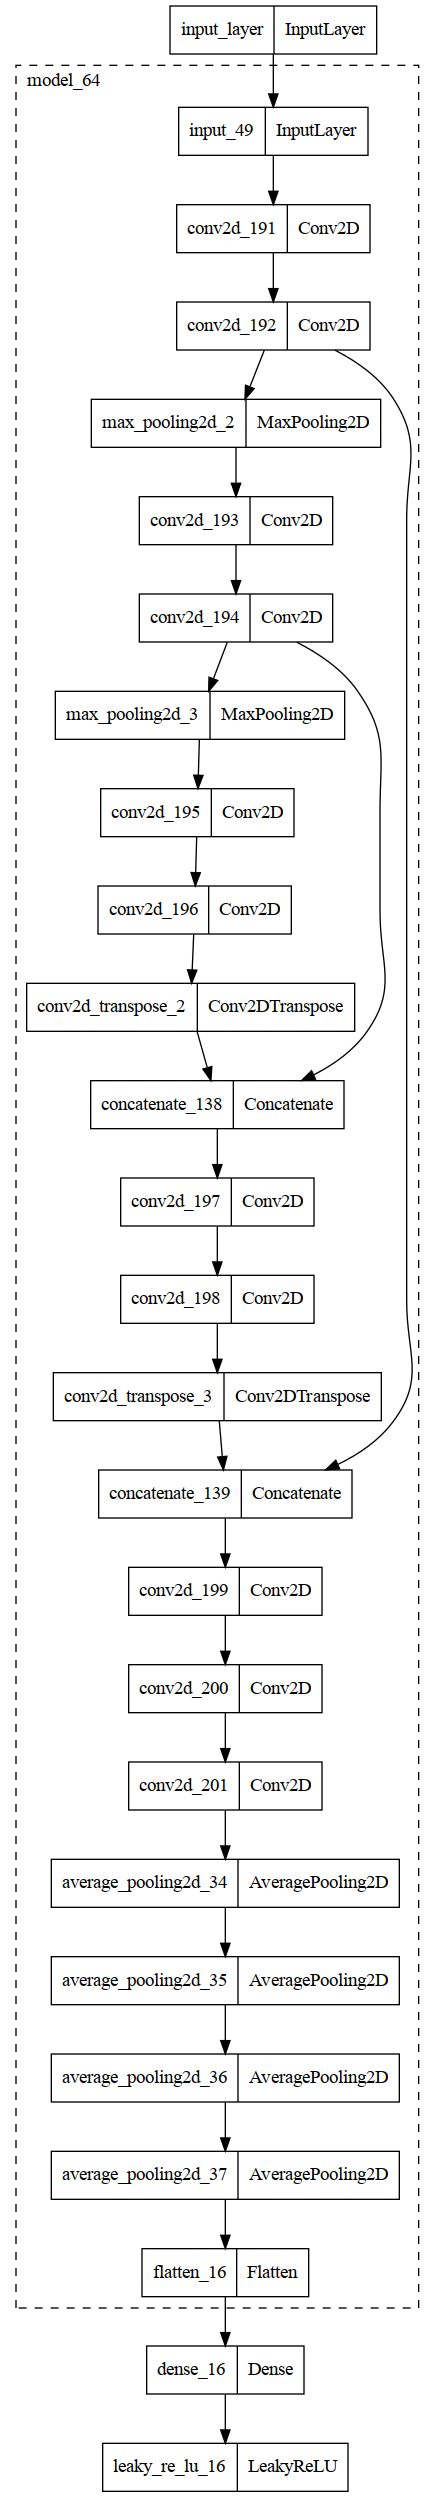

In [6]:
plot_model(model, expand_nested=True)

### Extra_valid data

In [7]:
data = model_eval.get_data_for_inversion(
    os.path.join(dir_res, name_model), path_extra_valid_nc
)

2024-01-03 17:35:52.063443: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [16]:
data.x.eval

<tf.Tensor: shape=(1152, 64, 64, 3), dtype=float32, numpy=
array([[[[ 0.03994527, -0.12678005, -1.2226086 ],
         [-0.65878284, -0.12678005, -1.2226086 ],
         [-0.37838066, -0.12677997, -1.2226083 ],
         ...,
         [-0.38424417, -0.27756965, -2.0254948 ],
         [-0.38299644, -0.27757794, -2.0256684 ],
         [-0.43972954, -0.2775784 , -2.0256782 ]],

        [[ 0.10494141, -0.11966134, -1.1226817 ],
         [-0.28538442, -0.11966134, -1.1226817 ],
         [-0.2436068 , -0.11966127, -1.1226816 ],
         ...,
         [-4.5498257 , -0.276563  , -2.023277  ],
         [-4.5498257 , -0.27657083, -2.0234542 ],
         [-4.5498257 , -0.27657127, -2.023464  ]],

        [[-0.45608982, -0.11992672, -1.1264063 ],
         [-0.47861028, -0.11992672, -1.1264062 ],
         [-0.59210265, -0.11992665, -1.1264061 ],
         ...,
         [-0.25837034, -0.2454248 , -1.954671  ],
         [-0.3949678 , -0.24541958, -1.9549642 ],
         [-0.32258117, -0.24541926, -1.954980

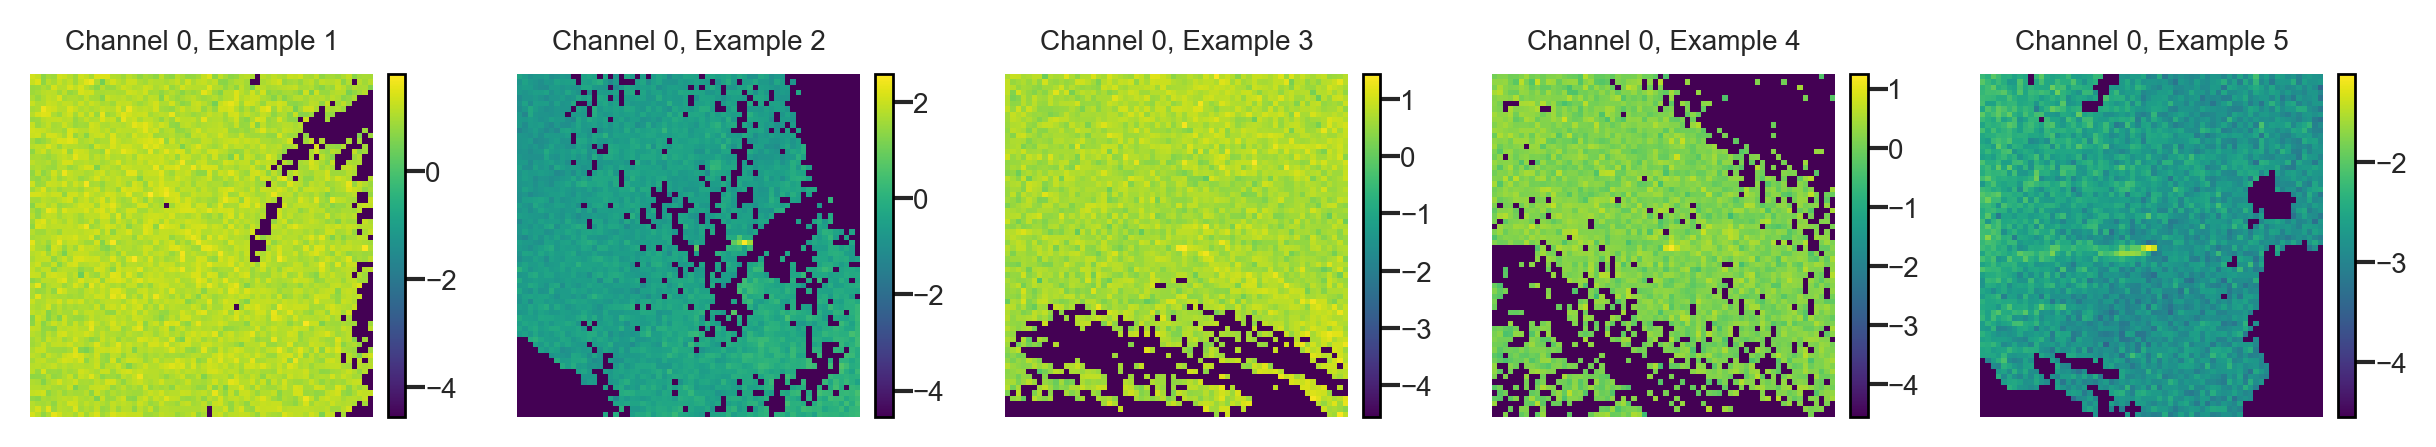

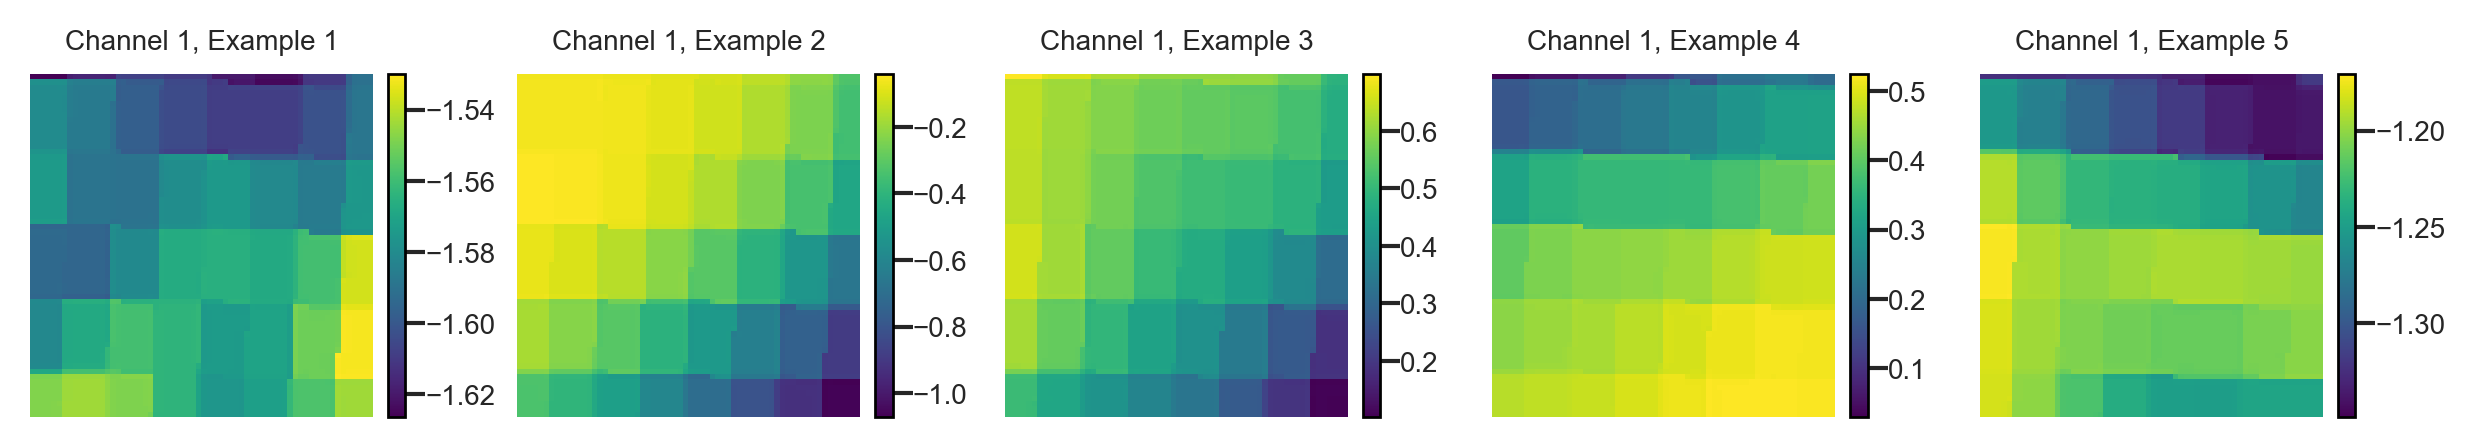

In [8]:
num_examples = 5
plot_data = data.x.eval
num_channels = plot_data.shape[-1]
example_indices = np.random.choice(plot_data.shape[0], num_examples, replace=False)

for channel in range(num_channels):
    if channel == 2:
        continue

    plt.figure(figsize=(num_examples * 2, 4))  # Adjust figure size as needed
    for i, idx in enumerate(example_indices):
        ax = plt.subplot(1, num_examples, i + 1)
        im = ax.imshow(plot_data[idx, :, :, channel], cmap="viridis")
        plt.title(f"Channel {channel}, Example {i + 1}")
        plt.axis("off")

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

2024-01-03 17:35:56.624054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-03 17:35:58.104140: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


36/36 [==============================] - 0s 4ms/step


<Figure size 1920x1440 with 0 Axes>

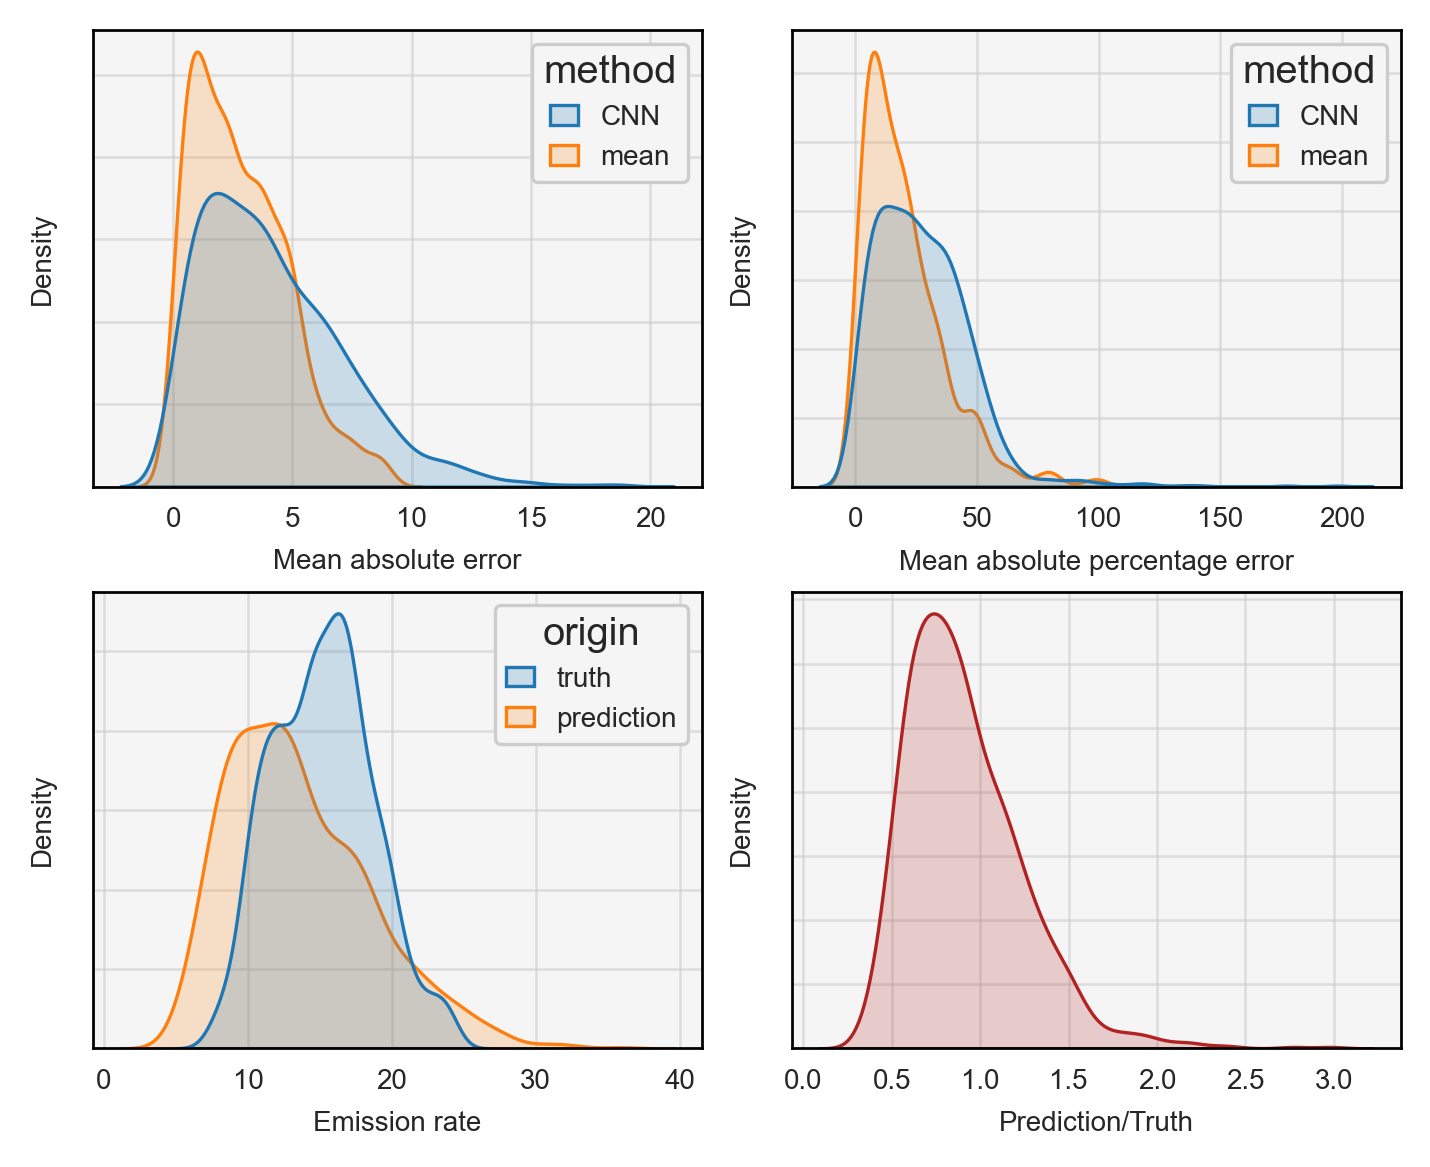

In [9]:
model_eval.get_summary_histo_inversion(model, data)

In [13]:
inv_eval = InversionModelEvaluation(model=model, data=data)
inv_eval.get_metrics()

36/36 [==============================] - 0s 4ms/step


{'mae': <tf.Tensor: shape=(1152,), dtype=float32, numpy=
 array([3.8791246 , 5.8930807 , 3.010641  , ..., 0.90678024, 4.637352  ,
        5.6302395 ], dtype=float32)>,
 'mape': <tf.Tensor: shape=(1152,), dtype=float32, numpy=
 array([20.446178, 33.885498, 19.283493, ...,  5.094185, 26.052406,
        31.943968], dtype=float32)>}

nwbce: 5.249456405639648
idx: 1087
origin: smart_2km_Lip_64
time: 2015-12-07T07:00:00.000000000
emiss: [18.84897 13.96177 12.38984]

nwbce: 9.546061515808105
idx: 25
origin: smart_2km_Lip_64
time: 2015-01-07T01:00:00.000000000
emiss: [14.22924 17.39116 19.96109]

nwbce: 0.6220998764038086
idx: 364
origin: smart_2km_Lip_64
time: 2015-04-22T04:00:00.000000000
emiss: [11.87363 11.5513  12.67409]

nwbce: 3.582207679748535
idx: 252
origin: smart_2km_Lip_64
time: 2015-03-21T12:00:00.000000000
emiss: [16.63039 17.19866 16.9149 ]



<Figure size 1920x1440 with 0 Axes>

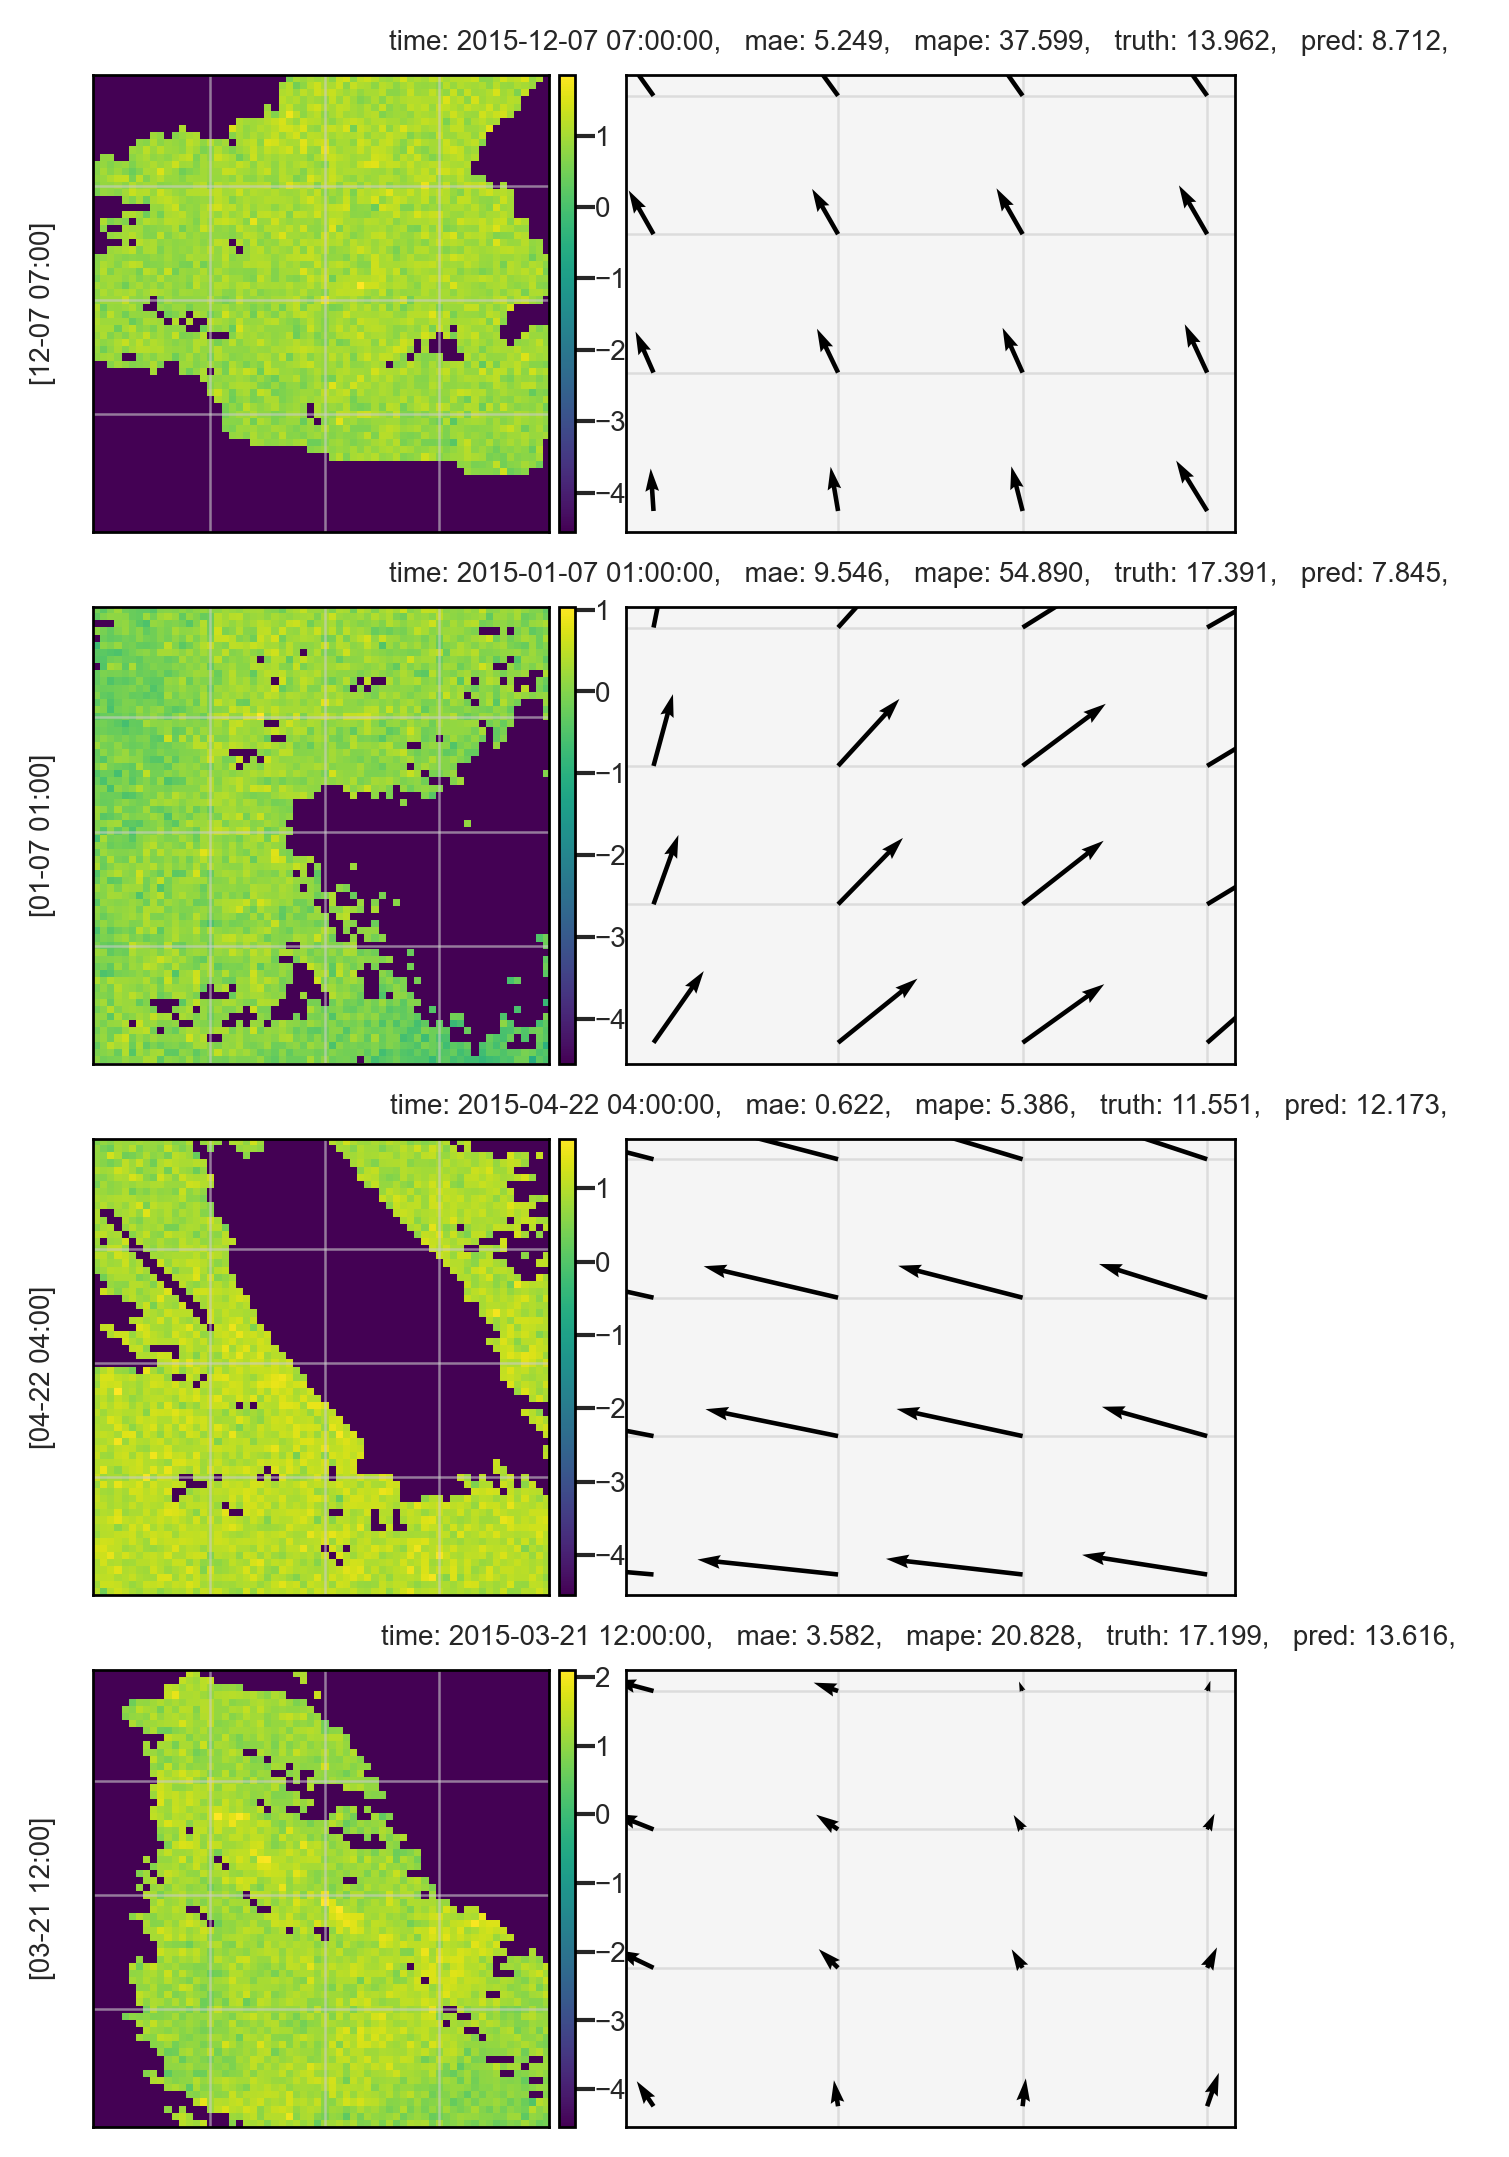

In [15]:
inv_plotter = InversionPlotter(inv_eval, cols_to_plot=[0, 1])
inv_plotter.plot_examples()

In [31]:
nested_model = model.get_layer("model_64")

# Now, get the 'conv2d_199' layer from the nested model.
layer_output = nested_model.get_layer("conv2d_201").output
intermediate_model = tf.keras.models.Model(
    inputs=nested_model.input, outputs=layer_output
)

In [35]:
random_index = np.random.randint(0, len(data.x.eval))
selected_image = data.x.eval[random_index].numpy().reshape(1, 64, 64, 3)
conv2d_199_output = intermediate_model.predict(selected_image)

1/1 [==============================] - 0s 31ms/step


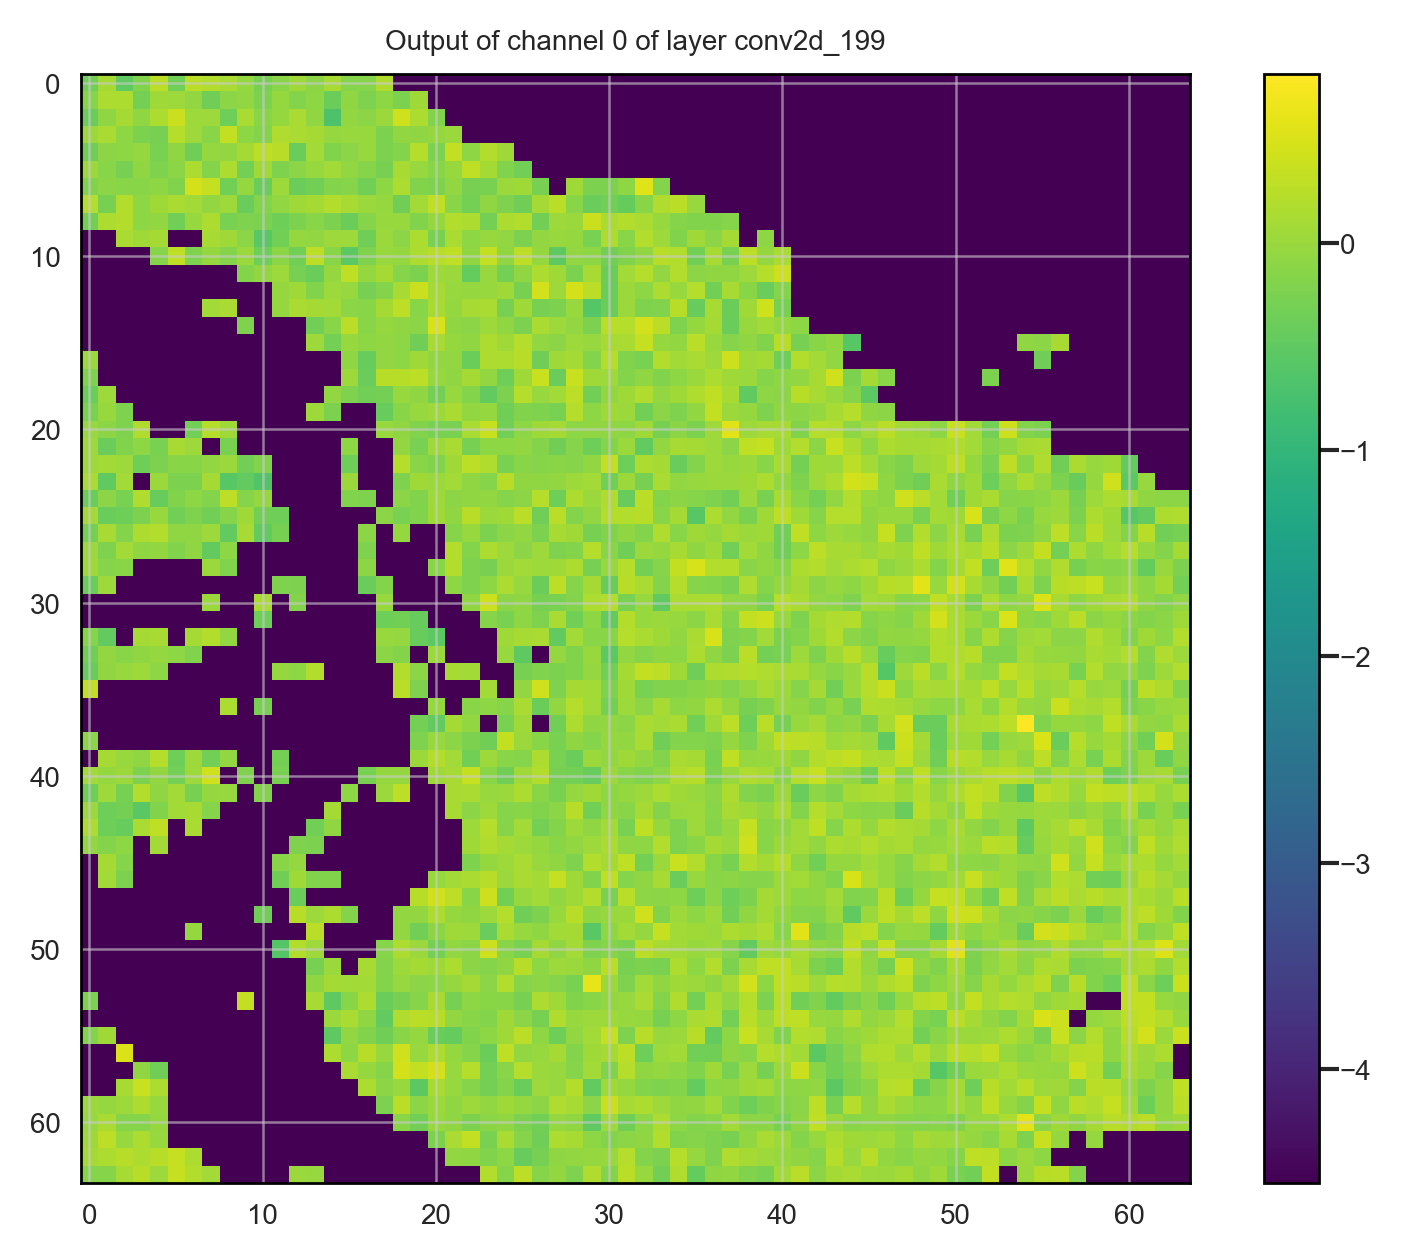

In [39]:
channel = 0
plt.imshow(data.x.eval[random_index, :, :, 0], cmap="viridis")
plt.title(f"Output of channel {channel} of layer conv2d_199")
plt.colorbar()
plt.show()

In [40]:
channel = 0
plt.imshow(conv2d_199_output[random_index, :, :, 4], cmap="viridis")
plt.title(f"Output of channel {channel} of layer conv2d_199")
plt.colorbar()
plt.show()

IndexError: index 1054 is out of bounds for axis 0 with size 1